# PHYS 320 Homework 4 Code Notebook
#### By Ansh Gupta

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

from astropy.cosmology import LambdaCDM
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import SphericalRepresentation
from astropy.coordinates import spherical_to_cartesian

## Problem 1

In [2]:
class cosmology():
    def __init__(self, H0=70, omega_m=0.3, omega_l=0.7):
        '''
        Class to facilitate cosmological computations in a
        universe with a critical density.

        Parameters:
        -----------
            H0: `int` or `float`
                Hubble parameter at z = 0
            omega_m: `int` or `float`
                Density parameter of matter
            omega_l: `int` or `float`
                Density parameter of dark energy
        '''
        self._H0 = H0 # hubble constant at z=0
        self._omega_m = omega_m # density parameter of matter
        self._omega_l = omega_l # density parameter of dark energy
        # density parameter equivalent from curvature (omega = 1)
        self._omega_k = 1 - omega_m - omega_l 
        self._c = 3e5 # speed of light in km/s
        self._D_H = self._c/H0 # hubble distance
    
    def _H(self, z):
        '''
        Compute the Hubble parameter at a given redshift.

        Inputs:
        -------
        z: `int`, `float`, or `numpy array`
            Redshift at which to compute the Hubble parameter

        Outputs:
        --------
        H: `float`
            Hubble parameter at redshift z (km/s / Mpc)
        '''

        # Friedmann equation in useful form from lecture notes
        H = self._H0 * np.sqrt( self._omega_m*(1+z)**3 + \
                              self._omega_k*(1+z)**2 + self._omega_l )
        return H

    def _D_C(self, z):
        '''
        Compute the comoving distance at a given redshift.

        Inputs:
        -------
        z: `int`, `float`, or `numpy array`
            Redshift at which to compute the Hubble parameter

        Outputs:
        --------
        D_C: `float`
            Comoving distance at redshift z (Mpc)
        '''

        # define c/H because that's the argument of the integral
        H_inv = lambda z: self._c / self._H(z)

        # if z is an int or float, just calculate r at that value
        if isinstance(z, (int, float)):
            D_C, _ = integrate.quad(H_inv, a=0, b=z)
            return D_C

        # otherwise assume z is an array, then compute r at each z value
        D_C = np.zeros_like(z)
        for i in range(len(z)):
            D_C[i], _ = integrate.quad(H_inv, a=0, b=z[i]) 
        return D_C

    def _D_M(self, z):
        '''
        Compute the transverse comoving distance (proper distance) at a
        given redshift as a function of cosmology.

        Inputs:
        -------
        z: `int`, `float`, or `numpy array`
            Redshift at which to compute the Hubble parameter

        Outputs:
        --------
        D_M: `float`
            Comoving distance at redshift z (Mpc)
        '''

        # if the universe if flat, D_M == comoving distance
        if self._omega_k == 0:
            D_M = self._D_C(z)
            return D_M

        # if not flat, use the analytic solution (Hogg 2000)
        if self._omega_k > 0:
            D_M = self._D_H * 1/np.sqrt(self._omega_k) * \
                  np.sinh(np.sqrt(self._omega_k)*self._D_C(z)/self._D_H)
        elif self._omega_k < 0:
            D_M = self._D_H * 1/np.sqrt(self._omega_k) * \
                  np.sin(np.sqrt(self._omega_k)*self._D_C(z)/self._D_H)
        return D_M


    def _D_A(self, z):
        '''
        Compute the angular diameter distance at a given redshift.

        Inputs:
        -------
        z: `int`, `float`, or `numpy array`
            Redshift at which to compute the Hubble parameter

        Outputs:
        --------
        D_A: `float`
            Angular diameter distance at redshift z (Mpc)
        '''
        D_A = self._D_M(z) / (1+z)
        return D_A

    def _D_L(self, z):
        '''
        Compute the luminosity distance at a given redshift.

        Inputs:
        -------
        z: `int`, `float`, or `numpy array`
            Redshift at which to compute the Hubble parameter

        Outputs:
        --------
        D_A: `float`
            Luminosity distance at redshift z (Mpc)
        '''
        D_L = self._D_M(z) * (1+z)
        return D_L

    def _distmod(self, z):
        '''
        Compute the distance modulus at a given redshift.

        Inputs:
        -------
        z: `int`, `float`, or `numpy array`
            Redshift at which to compute the Hubble parameter

        Outputs:
        --------
        distmod: `float`
            Distance modulus at redshift z
        '''
        D_L = self._D_L(z) # luminosity distance
        distmod = 5*np.log10(D_L*1e6/10)
        return distmod

    def _volume(self, z):
        '''
        Compute the differential comoving volume at a given redshift.

        Inputs:
        -------
        z: `int`, `float`, or `numpy array`
            Redshift at which to compute the Hubble parameter

        Outputs:
        --------
        V: `float`
             Differential volume per solid angle per unit 
             redshift (Mpc^3 / str)
        '''
        V = self._c * self._D_M(z)**2 / self._H(z)
        return V

    def _t(self, z):
        '''
        Compute the age of the universe at a given redshift.

        Inputs:
        -------
        z: `int`, `float`, or `numpy array`
            Redshift at which to compute the Hubble parameter

        Outputs:
        --------
        t: `float`
             Age of the universe at redshift z (Myr)
        '''
        # define the argument of the integral
        H_inv = lambda z: 1 / self._H(z) / (1+z)

        # if z is an int or float, just calculate t at that value
        if isinstance(z, (int, float)):
            t, _ = integrate.quad(H_inv, a=0, b=z)
            return t * 3.09e19 / 31500000 * 1e-6 # t in Myr

        # otherwise assume z is an array, then compute t at each z value
        t = np.zeros_like(z)
        for i in range(len(z)):
            t[i], _ = integrate.quad(H_inv, a=0, b=z[i])

        return t * 3.09e19 / 31500000 * 1e-6 # t in Myr

In [3]:
test_cosmo_1 = LambdaCDM(H0=70, Om0=1, Ode0=0)
test_cosmo_2 = LambdaCDM(H0=70, Om0=0.3, Ode0=0)
test_cosmo_3 = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

In [4]:
z = np.linspace(0.1, 5, 100)
cosmo_1 = cosmology(70, 1, 0)
cosmo_2 = cosmology(70, 0.3, 0)
cosmo_3 = cosmology(70, 0.3, 0.7)

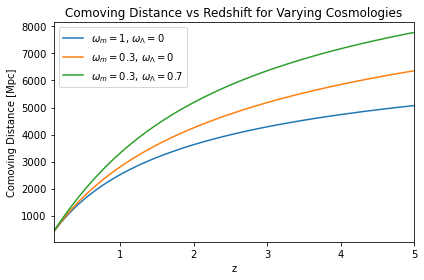

In [5]:
D_C1 = cosmo_1._D_C(z)
D_C2 = cosmo_2._D_C(z)
D_C3 = cosmo_3._D_C(z)

plt.title('Comoving Distance vs Redshift for Varying Cosmologies')
plt.xlabel('z')
plt.ylabel('Comoving Distance [Mpc]')
plt.xlim(0.1, 5)
plt.plot(z, D_C1, label=r'$\omega_m = 1$, $\omega_{\Lambda} = 0$')
plt.plot(z, D_C2, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0$')
plt.plot(z, D_C3, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0.7$')
plt.legend()
plt.tight_layout()

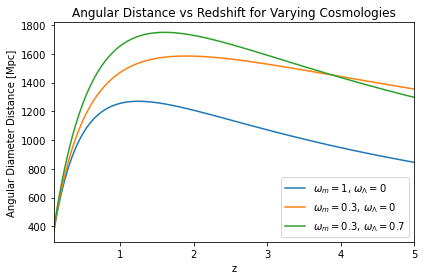

In [6]:
D_A1 = cosmo_1._D_A(z)
D_A2 = cosmo_2._D_A(z)
D_A3 = cosmo_3._D_A(z)

plt.title('Angular Distance vs Redshift for Varying Cosmologies')
plt.xlabel('z')
plt.ylabel('Angular Diameter Distance [Mpc]')
plt.xlim(0.1, 5)
plt.plot(z, D_A1, label=r'$\omega_m = 1$, $\omega_{\Lambda} = 0$')
plt.plot(z, D_A2, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0$')
plt.plot(z, D_A3, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0.7$')
plt.legend()
plt.tight_layout()

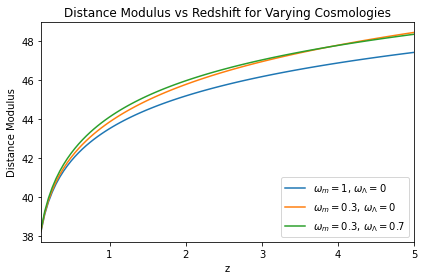

In [7]:
distmod1 = cosmo_1._distmod(z)
distmod2 = cosmo_2._distmod(z)
distmod3 = cosmo_3._distmod(z)

plt.title('Distance Modulus vs Redshift for Varying Cosmologies')
plt.xlabel('z')
plt.ylabel('Distance Modulus')
plt.xlim(0.1, 5)
plt.plot(z, distmod1, label=r'$\omega_m = 1$, $\omega_{\Lambda} = 0$')
plt.plot(z, distmod2, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0$')
plt.plot(z, distmod3, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0.7$')
plt.legend()
plt.tight_layout()

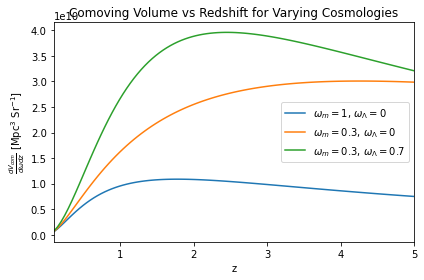

In [8]:
dV1 = cosmo_1._volume(z)
dV2 = cosmo_2._volume(z)
dV3 = cosmo_3._volume(z)

plt.title(r'Comoving Volume vs Redshift for Varying Cosmologies')
plt.xlabel('z')
plt.ylabel(r'$\frac{dV_{com}}{d{\omega}dz}$ [Mpc$^3$ Sr$^{-1}$]')
plt.xlim(0.1, 5)
plt.plot(z, dV1, label=r'$\omega_m = 1$, $\omega_{\Lambda} = 0$')
plt.plot(z, dV2, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0$')
plt.plot(z, dV3, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0.7$')
plt.legend()
plt.tight_layout()

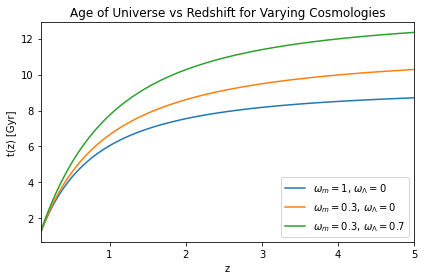

In [9]:
t1 = cosmo_1._t(z)
t2 = cosmo_2._t(z)
t3 = cosmo_3._t(z)

plt.title(r'Age of Universe vs Redshift for Varying Cosmologies')
plt.xlabel('z')
plt.ylabel('t(z) [Gyr]')
plt.xlim(0.1, 5)
plt.plot(z, t1/1000, label=r'$\omega_m = 1$, $\omega_{\Lambda} = 0$')
plt.plot(z, t2/1000, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0$')
plt.plot(z, t3/1000, label=r'$\omega_m = 0.3$, $\omega_{\Lambda} = 0.7$')
plt.legend()
plt.tight_layout()

## Problem 2

In [10]:
def mR_to_mK(d_i, m_R_i, z_f, cosmology):
    '''
    Compute the apparent K-band magnitude of a galaxy given
    a set of assumptions (listed in problem) given information
    about a similar galaxy in the local universe with a known
    R-band apparent magnitude.
    
    INPUTS:
    -------
    d_i: `float`
        Initial distance to the galaxy (Mpc)
    m_R_i: `float`
        Initial R-band apparent magnitude of the galaxy
    z_f: `float`
        Redshift at which galaxy is placed/reobserved
    cosmology: `cosmology object`
        Comology as defined earlier in this notebook
    
    OUTPUTS:
    --------
    m_K: `float`
        Apparent K-band magnitude of object at z=z_f
    '''
    
    d_i_pc = d_i * 1e6 # original distance to galaxy in pc
    distmod_i = 5*np.log10(d_i_pc/10) # distmod at d=d_i
    M_R = m_R_i - distmod_i # abs R-band mag of galaxy

    z_f = 1.5 # new redshift
    distmod_f = cosmology._distmod(z_f) # distmod at z=z_f
    m_R_f = M_R + distmod_f # app R-band mag at z=z_f

    # K-correction derivation in handwritten work below
    K = -2.5*np.log10(3080/640 * (1+z_f))
    m_K = m_R_f - K # app K-band mag at z=z_f
    return m_K

In [11]:
d_i = 7 # initial distance in Mpc
m_R_i = 10 # initial apparent R-band magnitude
z_f = 1.5 # final redshift of galaxy
print(f'Apparent K-band mangitude in Cosmology 1: {mR_to_mK(d_i, m_R_i, z_f, cosmo_1)}')
print(f'Apparent K-band mangitude in Cosmology 2: {mR_to_mK(d_i, m_R_i, z_f, cosmo_2)}')
print(f'Apparent K-band mangitude in Cosmology 3: {mR_to_mK(d_i, m_R_i, z_f, cosmo_3)}')

Apparent K-band mangitude in Cosmology 1: 27.95680222523002
Apparent K-band mangitude in Cosmology 2: 28.432027295855676
Apparent K-band mangitude in Cosmology 3: 28.665841419676816


A factor of $\frac{1}{(1+z)^2}$ comes in implicitly from the use of the luminosity distance in the distmod method. Then, I think a factor of $(1+z)$ comes in from the K-correction. I tried a derivation and attempted an explanation here:

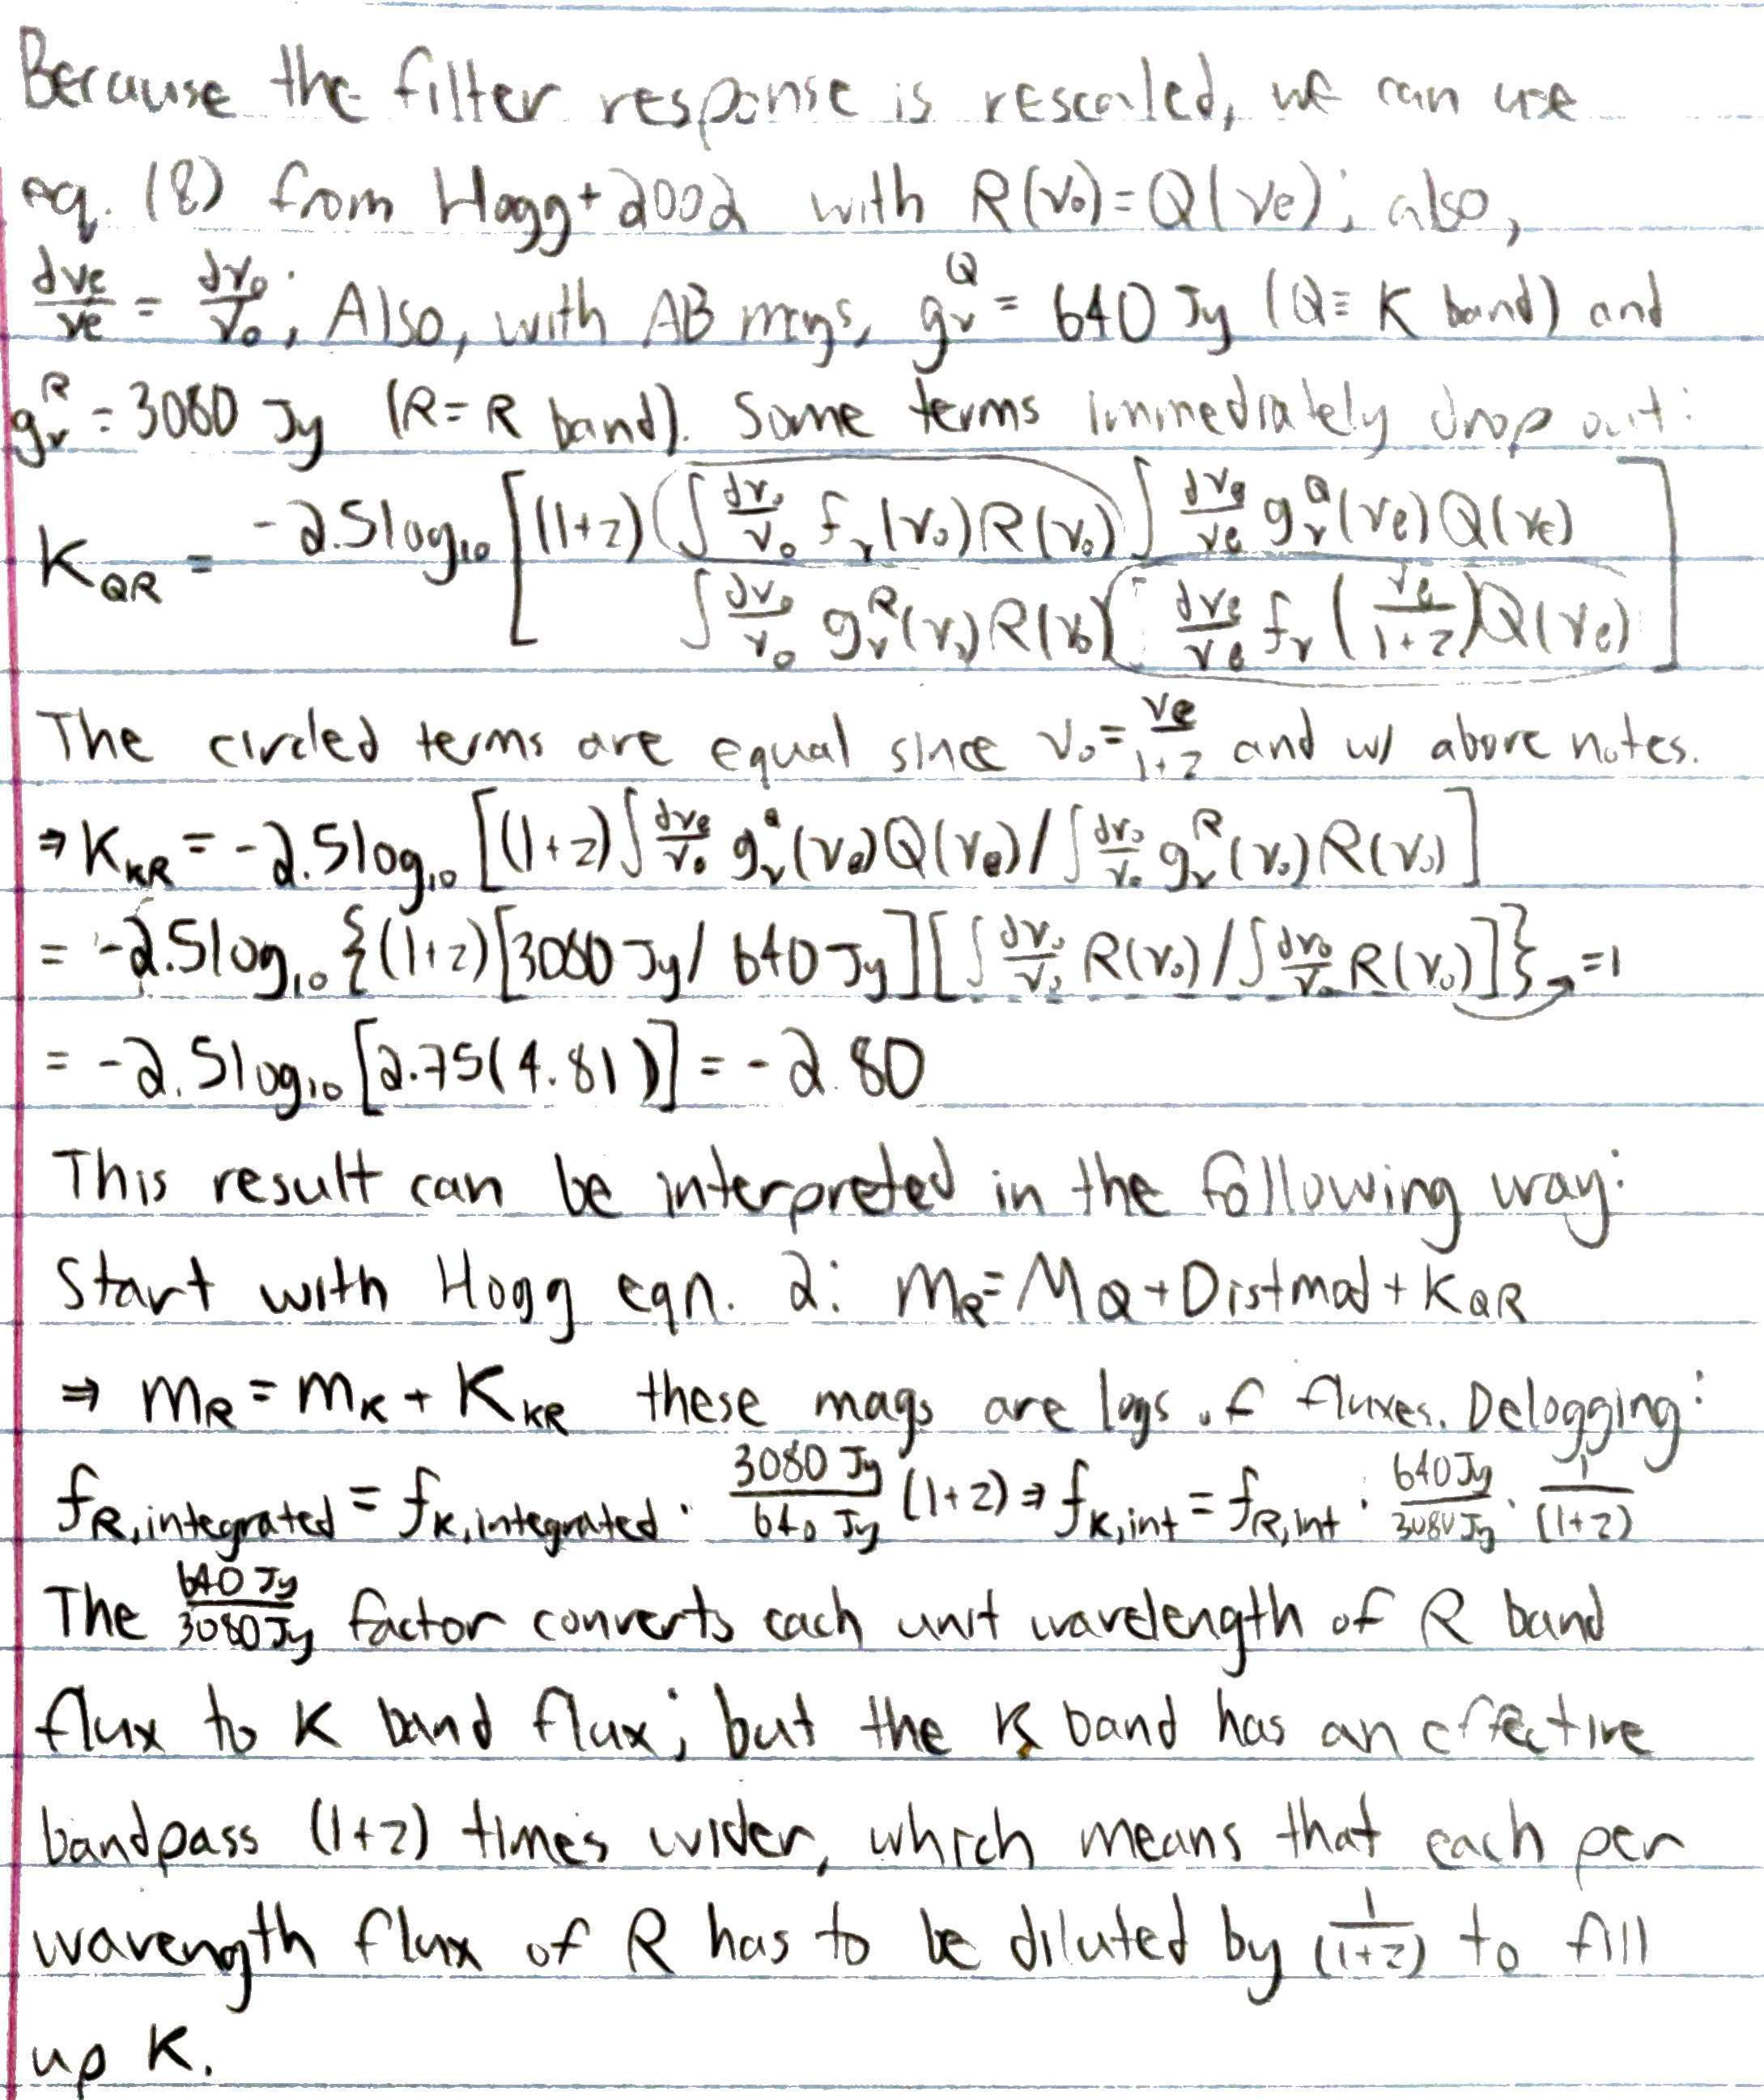

## Problem 3

In [12]:
def N_galaxies(n_gal, z_min, z_max, area, cosmology):
    '''
    Simple helper function to compute the expected number of galaxies
    that would be observed in an on-sky area assuming an unchanging
    number density and within a given redshift interval.
    
    INPUTS:
    -------
    n_gal: `float`
        Number density of galaxies in the local universe (Mpc^-3)
    z_min: `float`
        Lowest redshift targeted by the observations
    z_max: `float`
        Highest redshift targeted by the observations
    area: `float`
        On-sky area observed (Str)
    cosmology: `cosmology object`
        Comology as defined earlier in this notebook
    
    OUTPUTS:
    --------
    N_gal: `float`
        Number of galaxies expected to be observed    
    '''
    
    z_med = (z_min+z_max)/2 # avg redshift
    dz = z_max-z_min # width of redshift bin
    
    dV = cosmology._volume(z_med)
    N = dV * area * dz * n_gal
    return N

In [13]:
n_gal = 0.01 # number density of galaxies in local universe
z_min = 1.7
z_max = 1.8
area = (np.pi/180)**2 # definition of 1 sq. degree in str
print(f'Predicted number of galaxies in Cosmology 1: {N_galaxies(n_gal, z_min, z_max, area, cosmo_1):.5}')
print(f'Predicted number of galaxies in Cosmology 1: {N_galaxies(n_gal, z_min, z_max, area, cosmo_2):.5}')
print(f'Predicted number of galaxies in Cosmology 1: {N_galaxies(n_gal, z_min, z_max, area, cosmo_3):.6}')

Predicted number of galaxies in Cosmology 1: 3314.5
Predicted number of galaxies in Cosmology 1: 7279.9
Predicted number of galaxies in Cosmology 1: 11419.4


## Problem 4

In [14]:
def proper_separation(z, dz, dtheta, cosmology):
    '''
    Simple helper function to compute the proper separation
    between two galaxies at a given distance with a difference
    in redshift, assumed to be of cosmological origin, and an
    on-sky angular separation.
    
    INPUTS:
    -------
    z: `float`
        Approximate redshift of the two galaxies
    dz: `float`
        Difference in galaxy redshifts
    dtheta: `float`
        Angular separation between two galaxies (arcsec)
    cosmology: `cosmology object`
        Comology as defined earlier in this notebook
    
    OUTPUTS:
    --------
    D_M: `float`
        Proper distance between the two galaxies  
    '''
    
    D_M_t1 = cosmology._D_M(z + dz/2) # transverse proper distance 1
    D_M_t2 = cosmology._D_M(z - dz/2) # transverse proper distance 2
    D_M_t = D_M_t1 - D_M_t2 # transverse distance between galaxies
    
    D_A = cosmology._D_A(z) # angular distance
    dtheta_rad = dtheta / 3600 * (np.pi/180) # anglular sep. in rad
    D_M_a = D_A * dtheta_rad # tangential proper distance
    
    D_M = np.hypot(D_M_t, D_M_a) # Pythagorean addition of distances
    return D_M

In [15]:
z_gal = 1.75 # redshift of galaxies
dz = 0.003 # separation in redshift
dtheta = 40 # angular separation (arcsec)
print(f'Proper separation in Cosmology 1: {proper_separation(z_gal, dz, dtheta, cosmo_1):.3} Mpc')
print(f'Proper separation in Cosmology 2: {proper_separation(z_gal, dz, dtheta, cosmo_2):.3} Mpc')
print(f'Proper separation in Cosmology 3: {proper_separation(z_gal, dz, dtheta, cosmo_3):.3} Mpc')

Proper separation in Cosmology 1: 2.83 Mpc
Proper separation in Cosmology 2: 4.98 Mpc
Proper separation in Cosmology 3: 4.89 Mpc


## Problem 5

In [16]:
t_universe = 12 * 31500000 * 1e9 # age of universe in s
Mpc_to_km = 3.086e19 # this has units of km/Mpc

# Since in a cosmology with omega_m = 1, t = 2/3H, H = 2/3t; 
# multiplying the 1/s units with km/Mpc, we get km/s/Mpc as desired
print('Limit on H0 with omega_m = 1:', f'{2/3 / t_universe * Mpc_to_km:.3}', 'km/s/Mpc')

# Apply this same logic to more general cosmologies now

Limit on H0 with omega_m = 1: 54.4 km/s/Mpc


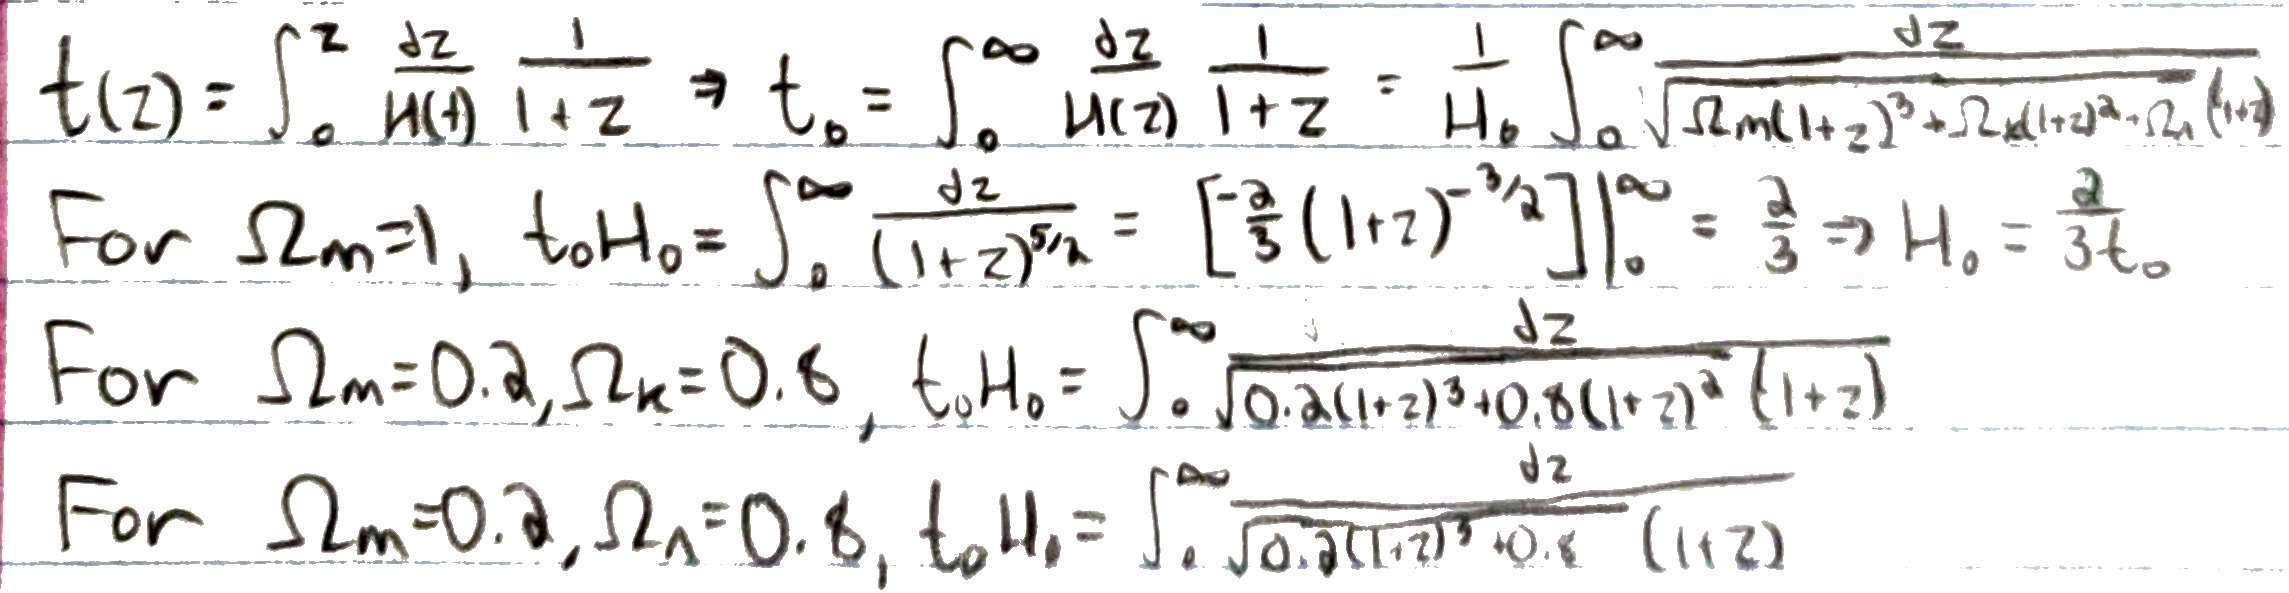

In [17]:
def t0H0(omega_m=0.3, omega_l=0.7):
    '''
    Function to calculate the product of the age of the universe,
    t0, and the Hubble parameter at z=0, H0. This leverages the
    fact that t0 equals the integral from 0 to infinity of:
        dz / H(z) * 1/(1+z)
    
    By rewriting H(z) in terms of the density parameters using
    the Friedmann equation, one can then arrive at an integral
    to compute t0*H0.
    
    INPUTS:
    -------
    omega_m: `float`
        The density parameter of matter at z=0
    omega_l: `float`
        The density parameter of dark energy at z=0
    
    OUTPUTS:
    --------
    t0H0: `float`
        The product of t0 and H0
    '''
    
    omega_k = 1 - omega_m - omega_l # From Friedmann equation
    
    # Definition of H(z)/H0
    H_H0 = lambda z: np.sqrt( omega_m*(1+z)**3 \
                             + omega_k*(1+z)**2 \
                             + omega_l )
    
    # Definition of integrand of t(z)*H0
    dt0H0 = lambda z: 1 / H_H0(z) / (1+z)
    
    # Carry out integral and return value
    t0H0, _ = integrate.quad(dt0H0, a=0, b=1e3)
    return t0H0

In [18]:
t0H0_1 = t0H0(omega_m=1, omega_l=0)
print('Limit on H0 with omega_m = 1:', f'{t0H0_1 / t_universe * Mpc_to_km:.3}', 'km/s/Mpc')

t0H0_2 = t0H0(omega_m=0.2, omega_l=0)
print('Limit on H0 with omega_m = 0.2, open model:', f'{t0H0_2 / t_universe * Mpc_to_km:.3}', 'km/s/Mpc')

t0H0_3 = t0H0(omega_m=0.2, omega_l=0.8)
print('Limit on H0 with omega_m = 0.2, flat model:', f'{t0H0_3 / t_universe * Mpc_to_km:.3}', 'km/s/Mpc')

Limit on H0 with omega_m = 1: 54.4 km/s/Mpc
Limit on H0 with omega_m = 0.2, open model: 69.1 km/s/Mpc
Limit on H0 with omega_m = 0.2, flat model: 87.8 km/s/Mpc
